In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import os
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import cv2 as cv

import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import multilabel_confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.activations import relu, sigmoid
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.metrics import Precision, Recall, AUC, Accuracy
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
base_dir = '../input'

In [3]:
cassava_dir = os.path.join(base_dir, 'cassava-leaf-disease-classification')
plant_village_dir = os.path.join(base_dir, 'plantvillage-dataset')
rice_dir = os.path.join(base_dir, 'rice-leaf-images/rice_images')

In [4]:
fnames = []

for dir in os.listdir(os.path.join(plant_village_dir, 'color')):
    columns = dir.split('___')
    columns.append(dir)
    fnames.append(columns)

In [5]:
fnames = pd.DataFrame(fnames, columns=['Tree type', 'Disease', 'Folder'])
fnames

,Tree type,Disease,Folder
0,Tomato,Late_blight,Tomato___Late_blight
1,Tomato,healthy,Tomato___healthy
2,Grape,healthy,Grape___healthy
3,Orange,Haunglongbing_(Citrus_greening),Orange___Haunglongbing_(Citrus_greening)
4,Soybean,healthy,Soybean___healthy
5,Squash,Powdery_mildew,Squash___Powdery_mildew
6,Potato,healthy,Potato___healthy
7,Corn_(maize),Northern_Leaf_Blight,Corn_(maize)___Northern_Leaf_Blight
8,Tomato,Early_blight,Tomato___Early_blight
9,Tomato,Septoria_leaf_spot,Tomato___Septoria_leaf_spot


In [6]:
fnames.drop([4,17,33],axis=0,inplace=True)

In [7]:
fnames['Disease'] = fnames['Disease'].str.replace('_', ' ')
fnames['Disease'] = fnames['Disease'].str.lstrip()
fnames['Tree type'] = fnames['Tree type'].str.replace('_', ' ')
fnames['Tree type'] = fnames['Tree type'].str.lstrip()
fnames

,Tree type,Disease,Folder
0,Tomato,Late blight,Tomato___Late_blight
1,Tomato,healthy,Tomato___healthy
2,Grape,healthy,Grape___healthy
3,Orange,Haunglongbing (Citrus greening),Orange___Haunglongbing_(Citrus_greening)
5,Squash,Powdery mildew,Squash___Powdery_mildew
6,Potato,healthy,Potato___healthy
7,Corn (maize),Northern Leaf Blight,Corn_(maize)___Northern_Leaf_Blight
8,Tomato,Early blight,Tomato___Early_blight
9,Tomato,Septoria leaf spot,Tomato___Septoria_leaf_spot
10,Corn (maize),Cercospora leaf spot Gray leaf spot,Corn_(maize)___Cercospora_leaf_spot Gray_leaf_...


In [8]:
os.mkdir('image data')

In [9]:
os.mkdir(os.path.join('image data', 'train'))
os.mkdir(os.path.join('image data', 'validation'))
os.mkdir(os.path.join('image data', 'test'))

In [10]:
train_path = os.path.join('image data/train')
val_path = os.path.join('image data/validation')
test_path = os.path.join('image data/test')

In [11]:
for tree in fnames['Tree type'].unique().tolist():
    # create directory for tree
    path_1 = os.path.join(train_path, tree)
    path_2 = os.path.join(test_path, tree)
    path_3 = os.path.join(val_path, tree)

    os.mkdir(path_1)
    os.mkdir(path_2)
    os.mkdir(path_3)

    for disease, folder in fnames[fnames['Tree type'] == tree][['Disease', 'Folder']].values.tolist():
        # create directory to each disease
        sub_path_1 = os.path.join(path_1, disease.strip())
        sub_path_2 = os.path.join(path_2, disease.strip())
        sub_path_3 = os.path.join(path_3, disease.strip())

        os.mkdir(sub_path_1)
        os.mkdir(sub_path_2)
        os.mkdir(sub_path_3)

        # read data from source folder
        src = os.path.join(plant_village_dir, 'color', folder)
        image_count = len(os.listdir(src))
        test_img_count = image_count // 10
        val_img_count = (image_count - test_img_count) // 5
        train_img_count = image_count - (test_img_count + val_img_count)
        counts = [train_img_count, test_img_count, val_img_count]
        splits = [sub_path_1, sub_path_2, sub_path_3]

        for i in range(3):
            images = os.listdir(src)
            for j in images[:counts[i]]:
                shutil.copyfile(src=os.path.join(src, j),
                                dst=os.path.join(splits[i], j))

In [12]:
os.mkdir(os.path.join(train_path, 'Rice'))
os.mkdir(os.path.join(test_path, 'Rice'))
os.mkdir(os.path.join(val_path, 'Rice'))

In [13]:
source_dirs = os.listdir(rice_dir)

for source in source_dirs:
    src = os.path.join(rice_dir, source)
    image_count = len(os.listdir(src))
    test_img_count = image_count // 10
    val_img_count = (image_count - test_img_count) // 5
    train_img_count = image_count - (test_img_count + val_img_count)
    path_1 = os.path.join('image data/train/Rice', source.replace('_', ''))
    path_2 = os.path.join('image data/test/Rice', source.replace('_', ''))
    path_3 = os.path.join('image data/validation/Rice', source.replace('_', ''))

    os.mkdir(path_1)
    os.mkdir(path_2)
    os.mkdir(path_3)
    paths = [path_1, path_2, path_3]
    split_counts = [train_img_count, test_img_count, val_img_count]

    for i in range(3):
        images = os.listdir(src)
        for j in images[:split_counts[i]]:
            shutil.copyfile(src=os.path.join(src, j),
                        dst=os.path.join(paths[i], j))

In [14]:
# disease_map = {0: "Bacterial Blight (CBB)",
#                1: "Brown Streak Disease (CBSD)",
#                2: "Green Mottle (CGM)",
#                3: "Mosaic Disease (CMD)",
#                4: "Healthy"}

In [15]:
# pd.read_csv('../input/cassava-leaf-disease-classification/train.csv')['label'].value_counts()

In [16]:
# os.mkdir(os.path.join(train_path, 'Cassava'))
# os.mkdir(os.path.join(test_path, 'Cassava'))
# os.mkdir(os.path.join(val_path, 'Cassava'))

In [17]:
# for disease in disease_map.values():
#     os.mkdir(os.path.join('image data/train/Cassava', disease))
#     os.mkdir(os.path.join('image data/test/Cassava', disease))
#     os.mkdir(os.path.join('image data/validation/Cassava', disease))

In [18]:
# df = pd.read_csv('../input/cassava-leaf-disease-classification/train.csv')

# for img in df[df['label'] == 0].reset_index().loc[:378, 'image_id']:
#     src = os.path.join(cassava_dir, 'train_images', img)
#     dst = os.path.join('image data/train/Cassava', disease_map[0], img)

#     if os.path.isfile(src):
#         shutil.copyfile(src, dst)

# for img in df[df['label'] == 0].reset_index().loc[378:486, 'image_id']:
#     src = os.path.join(cassava_dir, 'train_images', img)
#     dst = os.path.join('image data/test/Cassava', disease_map[0], img)

#     if os.path.isfile(src):
#         shutil.copyfile(src, dst)

# for img in df[df['label'] == 0].reset_index().loc[486:540, 'image_id']:
#     src = os.path.join(cassava_dir, 'train_images', img)
#     dst = os.path.join('image data/validation/Cassava', disease_map[0], img)

#     if os.path.isfile(src):
#         shutil.copyfile(src, dst)

In [19]:
# for i in range(1,4):
#     for img in df[df['label'] == i].reset_index().loc[:448, 'image_id']:
#         src = os.path.join(cassava_dir, 'train_images', img)
#         dst = os.path.join('image data/train/Cassava', disease_map[i], img)

#         if os.path.isfile(src):
#             shutil.copyfile(src, dst)

#     for img in df[df['label'] == i].reset_index().loc[448:572, 'image_id']:
#         src = os.path.join(cassava_dir, 'train_images', img)
#         dst = os.path.join('image data/test/Cassava', disease_map[i], img)

#         if os.path.isfile(src):
#             shutil.copyfile(src, dst)

#     for img in df[df['label'] == i].reset_index().loc[572:634, 'image_id']:
#         src = os.path.join(cassava_dir, 'train_images', img)
#         dst = os.path.join('image data/validation/Cassava', disease_map[i], img)

#         if os.path.isfile(src):
#             shutil.copyfile(src, dst)

In [20]:
# for img in df[df['label'] == 4].reset_index().loc[:708, 'image_id']:
#     src = os.path.join(cassava_dir, 'train_images', img)
#     dst = os.path.join('image data/train/Cassava', disease_map[4], img)

#     if os.path.isfile(src):
#         shutil.copyfile(src, dst)

# for img in df[df['label'] == 4].reset_index().loc[708:910, 'image_id']:
#     src = os.path.join(cassava_dir, 'train_images', img)
#     dst = os.path.join('image data/test/Cassava', disease_map[4], img)

#     if os.path.isfile(src):
#         shutil.copyfile(src, dst)

# for img in df[df['label'] == 4].reset_index().loc[910:1011, 'image_id']:
#     src = os.path.join(cassava_dir, 'train_images', img)
#     dst = os.path.join('image data/validation/Cassava', disease_map[4], img)

#     if os.path.isfile(src):
#         shutil.copyfile(src, dst)

## modeling

In [21]:
tree_types = os.listdir('image data/train')
X = []
y = []
val_x = []
val_y = []

for tree in tree_types:
    tree_path = os.path.join('image data/train', tree)
    tree_disease_types = os.listdir(tree_path)

    for disease in tree_disease_types:
        img_name = os.listdir(os.path.join(tree_path, disease))

        for img in img_name:
            image_path = os.path.join(tree_path, disease, img)
            image = cv.resize(cv.imread(image_path), dsize=(32, 32))
            X.append(image)
            y.append([tree, disease])
            
for tree in tree_types:
    tree_path = os.path.join('image data/validation', tree)
    tree_disease_types = os.listdir(tree_path)

    for disease in tree_disease_types:
        img_name = os.listdir(os.path.join(tree_path, disease))

        for img in img_name:
            image_path = os.path.join(tree_path, disease, img)
            image = cv.resize(cv.imread(image_path), dsize=(32, 32))
            val_x.append(image)
            val_y.append([tree, disease])

In [22]:
test_x = []
test_y = []

for tree in tree_types:
    tree_path = os.path.join('image data/test', tree)
    tree_disease_types = os.listdir(tree_path)

    for disease in tree_disease_types:
        img_name = os.listdir(os.path.join(tree_path, disease))

        for img in img_name:
            image_path = os.path.join(tree_path, disease, img)
            image = cv.resize(cv.imread(image_path), dsize=(32, 32))
            test_x.append(image)
            test_y.append([tree, disease])

In [23]:
X = np.array(X)
val_x = np.array(val_x)
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(y)
val_y = mlb.transform(val_y)

In [24]:
test_y = mlb.transform(test_y)

In [25]:
test_x = np.array(test_x)/255
val_x = val_x/255

In [26]:
X.shape, y.shape

((36531, 32, 32, 3), (36531, 37))

In [27]:
generator = ImageDataGenerator(rescale=1. / 255,
                                     rotation_range=15,
                                     width_shift_range=0.1,
                                     height_shift_range=0.1,
                                     horizontal_flip=True,
                                     vertical_flip=True
                                    )
generator.fit(X)

In [28]:
check_pointer = ModelCheckpoint(filepath='exp_conv_8.hdf5',
                                save_best_only=True)

early_stop = EarlyStopping(monitor='val_loss',
                           patience=40,
                           min_delta=0,
                           restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.1,
                              patience=20)

In [29]:
base_units = 32
weight_decay = 1e-4
exp_conv = Sequential()

exp_conv.add(InputLayer(input_shape=(32, 32, 3)))

# conv 1
exp_conv.add(Conv2D(filters=base_units, kernel_size=(3, 3), kernel_regularizer=l2(weight_decay), padding='same',
                    activation=relu))
exp_conv.add(BatchNormalization())

# conv 2
exp_conv.add(Conv2D(filters=base_units, kernel_size=(3, 3), kernel_regularizer=l2(weight_decay), padding='same',
                    activation=relu))
exp_conv.add(BatchNormalization())

# pool and dropout
exp_conv.add(MaxPooling2D(pool_size=(2, 2)))
exp_conv.add(Dropout(0.2))

# conv 3
exp_conv.add(Conv2D(filters=base_units * 2, kernel_size=(3, 3), kernel_regularizer=l2(weight_decay), padding='same',
                    activation=relu))
exp_conv.add(BatchNormalization())

# conv 4
exp_conv.add(Conv2D(filters=base_units * 2, kernel_size=(3, 3), kernel_regularizer=l2(weight_decay), padding='same',
                    activation=relu))
exp_conv.add(BatchNormalization())

# pool and dropout
exp_conv.add(MaxPooling2D(pool_size=(2, 2)))
exp_conv.add(Dropout(0.3))

# conv 5
exp_conv.add(Conv2D(filters=base_units * 4, kernel_size=(3, 3), kernel_regularizer=l2(weight_decay), padding='same',
                    activation=relu))
exp_conv.add(BatchNormalization())

# conv 6
exp_conv.add(Conv2D(filters=base_units * 4, kernel_size=(3, 3), kernel_regularizer=l2(weight_decay), padding='same',
                    activation=relu))
exp_conv.add(BatchNormalization())

# pool and dropout
exp_conv.add(MaxPooling2D(pool_size=(2, 2)))
exp_conv.add(Dropout(0.4))

# fully connected
exp_conv.add(Flatten())
exp_conv.add(Dense(units=y.shape[1], activation=sigmoid))

exp_conv.summary()

2022-01-03 17:53:54.593405: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-03 17:53:54.696018: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-03 17:53:54.697062: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-03 17:53:54.699229: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        1

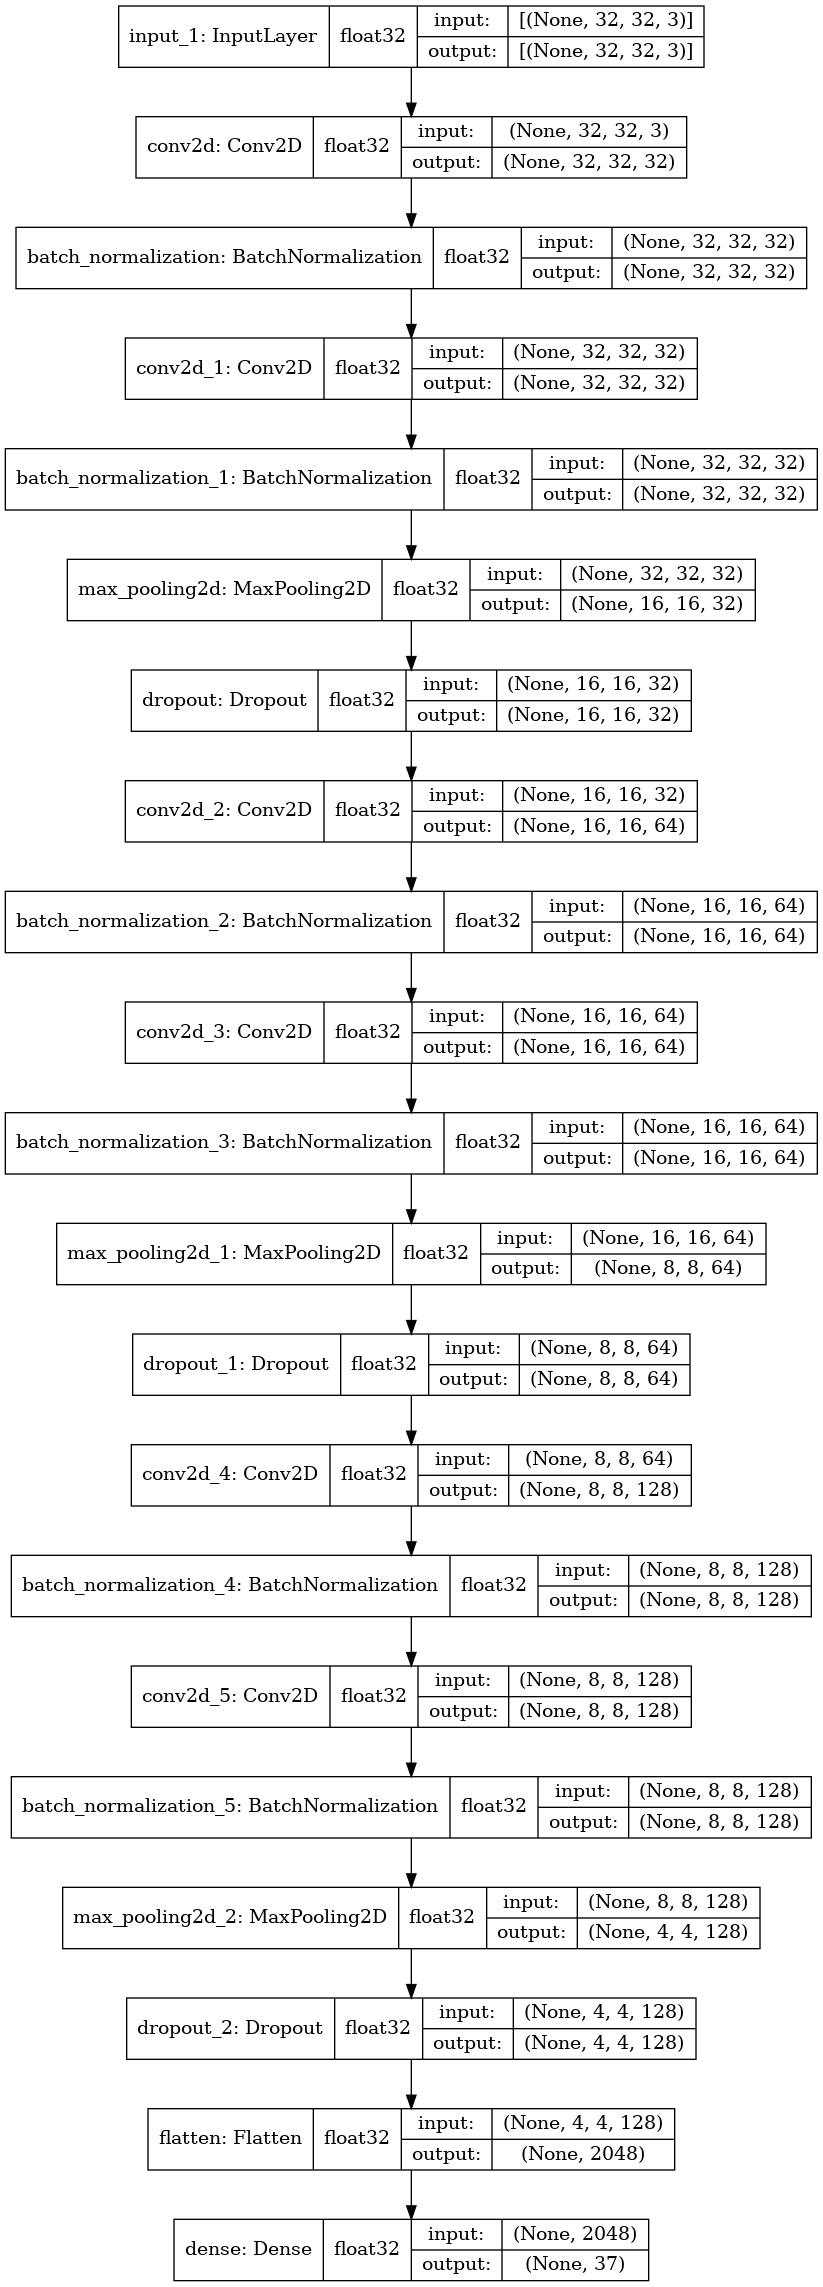

In [30]:
plot_model(exp_conv,
           to_file='baseline_conv_10_exp.png',
           show_shapes=True,
           show_dtype=True,
           show_layer_names=True)

In [31]:
# train = generator.flow(X, y, batch_size=32, subset='training')
# val = generator.flow(X, y, batch_size=32, subset='validation')

In [32]:
exp_conv.compile(optimizer=Adam(),
                   loss=binary_crossentropy,
                   metrics=[Recall(), Precision(), 'accuracy', AUC()])

history = exp_conv.fit(generator.flow(X,y, batch_size=32), 
                        epochs=200, 
                        validation_data=(val_x,val_y),
                        callbacks=[early_stop, check_pointer, reduce_lr])

2022-01-03 17:53:59.257500: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/200


2022-01-03 17:54:02.102937: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


1142/1142 [==============================] - 45s 31ms/step - loss: 0.1460 - recall: 0.5318 - precision: 0.6923 - accuracy: 0.2639 - auc: 0.9386 - val_loss: 0.1102 - val_recall: 0.6467 - val_precision: 0.7910 - val_accuracy: 0.2411 - val_auc: 0.9682
Epoch 2/200
1142/1142 [==============================] - 35s 31ms/step - loss: 0.0932 - recall: 0.7025 - precision: 0.8186 - accuracy: 0.3170 - auc: 0.9789 - val_loss: 0.1024 - val_recall: 0.6911 - val_precision: 0.7736 - val_accuracy: 0.2962 - val_auc: 0.9714
Epoch 3/200
1142/1142 [==============================] - 35s 31ms/step - loss: 0.0750 - recall: 0.7749 - precision: 0.8587 - accuracy: 0.3217 - auc: 0.9868 - val_loss: 0.1354 - val_recall: 0.6118 - val_precision: 0.7083 - val_accuracy: 0.3208 - val_auc: 0.9396
Epoch 4/200
1142/1142 [==============================] - 35s 31ms/step - loss: 0.0654 - recall: 0.8157 - precision: 0.8839 - accuracy: 0.3428 - auc: 0.9910 - val_loss: 0.0886 - val_recall: 0.7563 - val_precision: 0.8191 - val_acc

In [33]:
exp_conv.evaluate(test_x,test_y) 

158/158 [==============================] - 1s 7ms/step - loss: 0.0101 - recall: 0.9751 - precision: 0.9773 - accuracy: 0.4757 - auc: 0.9994


[0.010096697136759758,
 0.9750692248344421,
 0.9772930145263672,
 0.47566282749176025,
 0.9994388818740845]

In [34]:
exp_conv.save('best_net_82.hdf5')

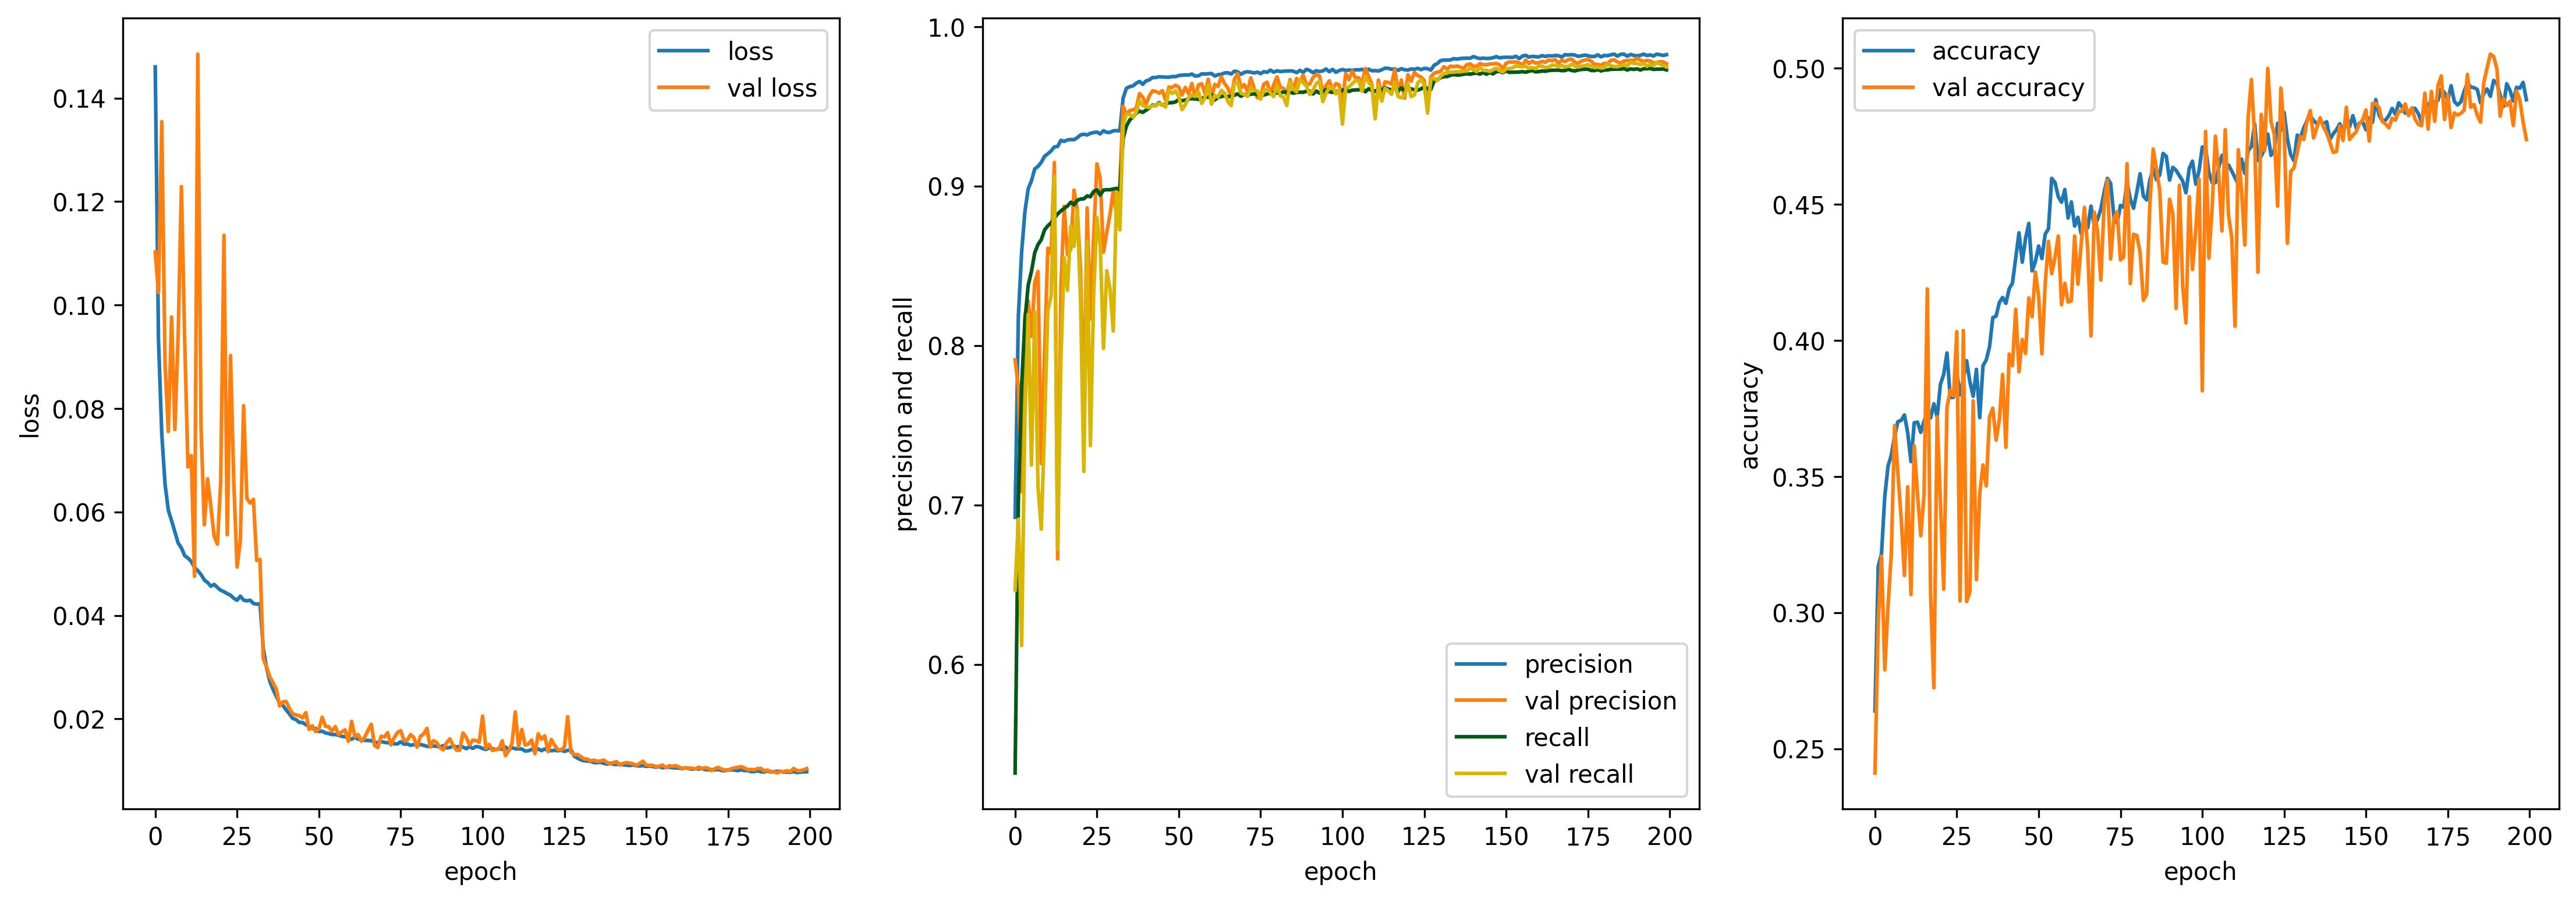

In [35]:
figure, axes = plt.subplots(nrows=1, ncols=3, figsize=[18, 6], dpi=300)
axes = axes.ravel()
epochs = list(range(len(history.history['loss'])))

sns.lineplot(x=epochs, y=history.history['loss'], ax=axes[0],label='loss')
sns.lineplot(x=epochs, y=history.history['val_loss'], ax=axes[0],label='val loss')
sns.lineplot(x=epochs, y=history.history['precision'], ax=axes[1],label='precision')
sns.lineplot(x=epochs, y=history.history['val_precision'], ax=axes[1],label='val precision')
sns.lineplot(x=epochs, y=history.history['recall'], color='#025918', ax=axes[1],label='recall')
sns.lineplot(x=epochs, y=history.history['val_recall'], color='#D9B504',ax=axes[1],label='val recall')
sns.lineplot(x=epochs, y=history.history['accuracy'], ax=axes[2],label='accuracy')
sns.lineplot(x=epochs, y=history.history['val_accuracy'], ax=axes[2],label='val accuracy')
axes[0].set_xlabel('epoch')
axes[0].set_ylabel('loss')
axes[1].set_xlabel('epoch')
axes[1].set_ylabel('precision and recall')
axes[2].set_xlabel('epoch')
axes[2].set_ylabel('accuracy')
plt.savefig('VGGNet_base_conv_train_history.png')
plt.show()

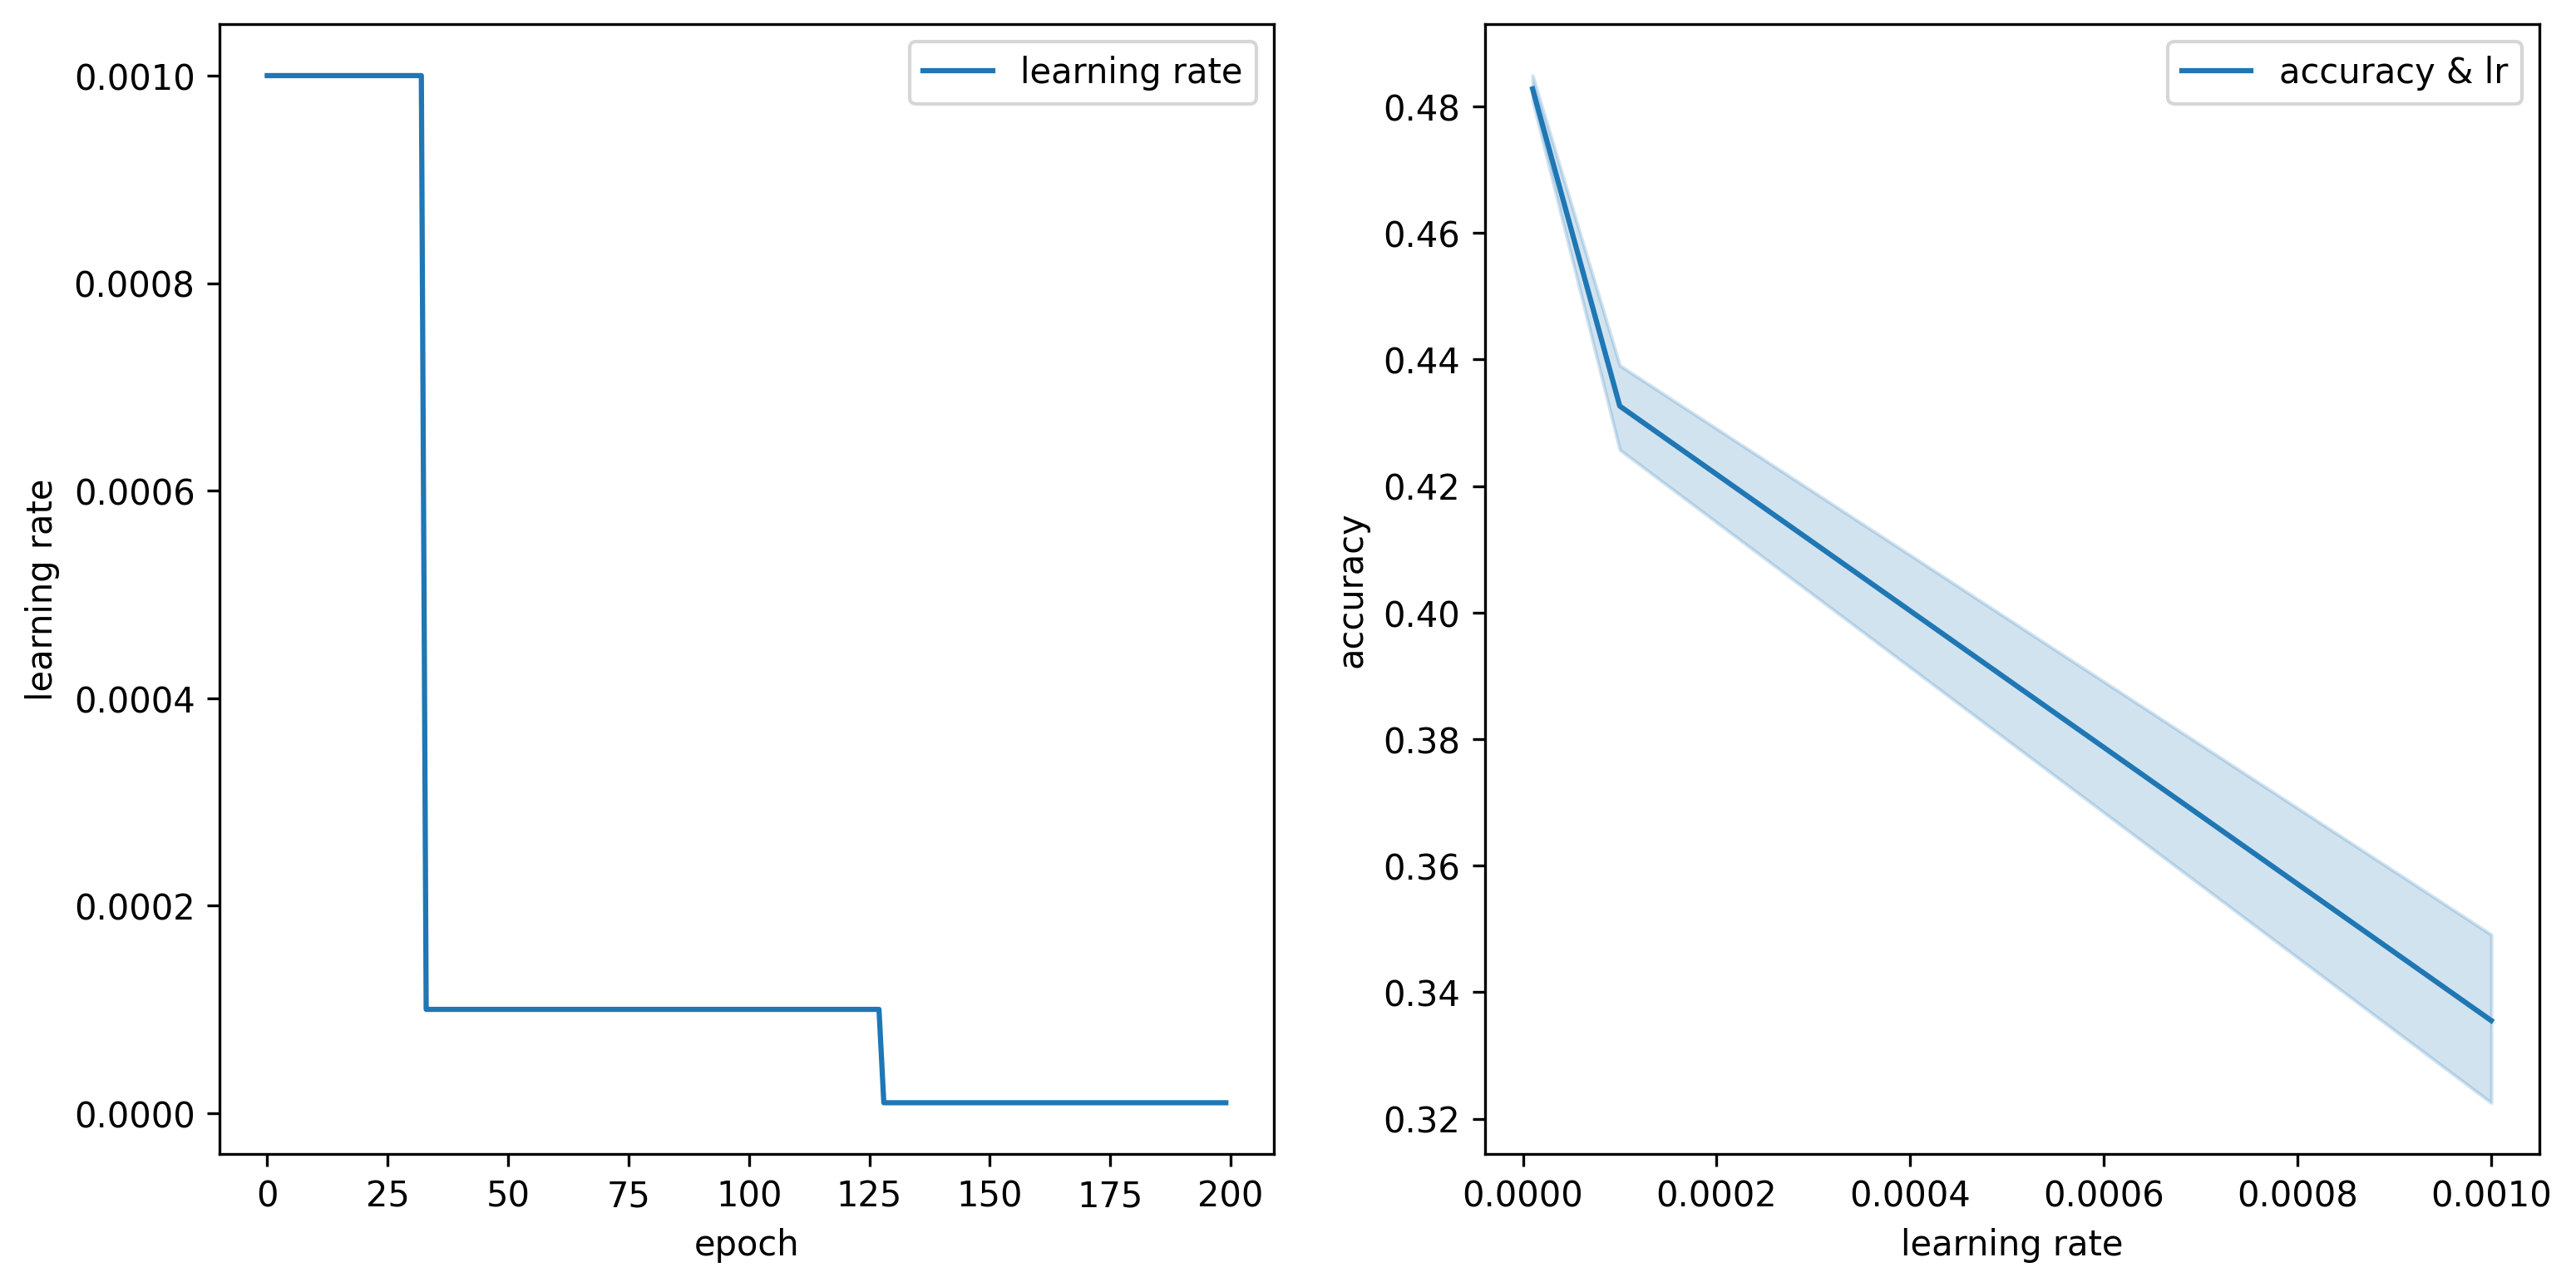

In [36]:
figure, axes = plt.subplots(nrows=1, ncols=2, figsize=[12, 6], dpi=300)
axes = axes.ravel()

sns.lineplot(x=epochs, y=history.history['lr'], ax=axes[0],label='learning rate')
sns.lineplot(x=history.history['lr'], y=history.history['val_accuracy'], ax=axes[1],label='accuracy & lr')
axes[0].set_xlabel('epoch')
axes[0].set_ylabel('learning rate')
axes[1].set_xlabel('learning rate')
axes[1].set_ylabel('accuracy')

plt.savefig('AlexNet_base_conv_lr_history.png')
plt.show()

In [37]:
# Plot confusion matrix
fig, axes = plt.subplots(nrows=7, ncols=6, figsize=[64, 42], dpi=300)
axes = axes.ravel()

preds = np.where(exp_conv.predict(test_x) < 0.65, 0, 1)
confusion = multilabel_confusion_matrix(test_y, preds)

for i, (label, matrix) in enumerate(zip(mlb.classes_, confusion)):
    labels = [f'not_{label}', label]
    sns.heatmap(matrix, annot=True, square=True, fmt='d', cbar=False, cmap='Blues',
                xticklabels=labels, yticklabels=labels, linecolor='black', linewidth=1,
                ax=axes[i])
    axes[i].set_title(labels[0])

plt.savefig('AlexNet_base_conv_7_cm.png')
plt.show()

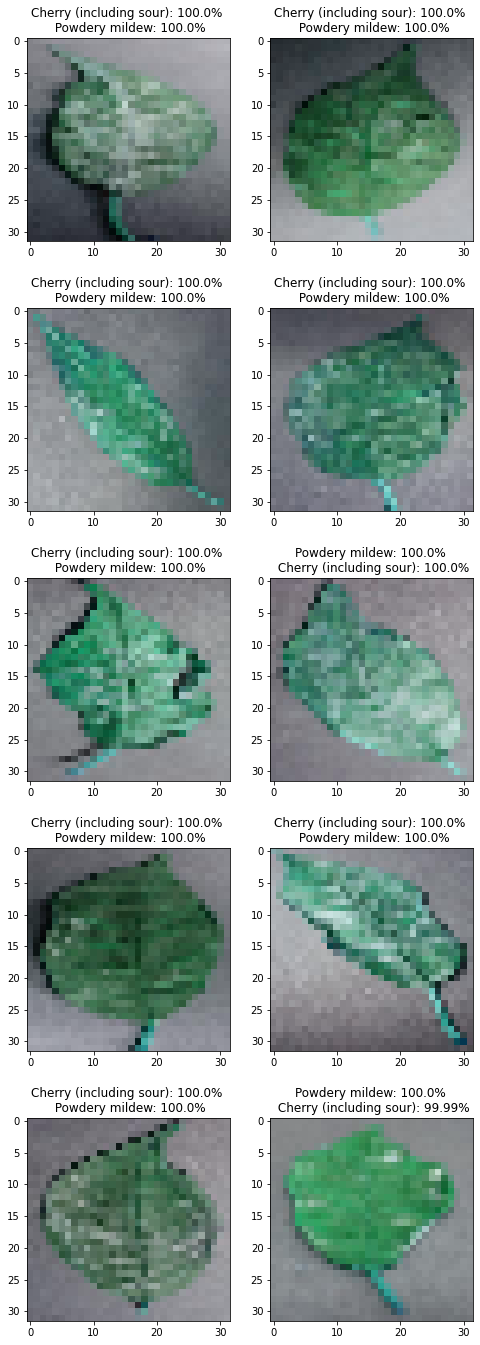

In [38]:
fig, axes = plt.subplots(nrows=5, ncols=2,figsize = (8, 24))
preds = exp_conv.predict(test_x[:10])
axes = axes.ravel()

for i in range(len(preds)):
    p = zip(list(mlb.classes_), list(preds[i]))
    p = sorted(list(p), key = lambda z: z[1], reverse = True)[:2]
    axes[i].imshow(test_x[i])
    axes[i].set_title(f'{p[0][0]}: {round(p[0][1] * 100, 2)}% \n {p[1][0]}: {round(p[1][1] * 100, 2)}%')
    